## Tutorial 2 - Turbojet Aircraft Simulation
Welcome to this tutorial on simulating a turbojet aircraft using RCAIDE. This guide will walk you through the code, explain its components, and highlight where modifications can be made to customize the simulation for different vehicle designs.

---

## Header and Imports

The **Imports** section is divided into two parts: simulation-specific libraries and general-purpose Python libraries.

The **RCAIDE Imports** section includes the core modules needed for the simulation. These libraries provide specialized classes and tools for building, analyzing, and running aircraft models.


In [1]:
# RCAIDE imports 
import RCAIDE  
from RCAIDE.Framework.Core                                  import Units , Data    
from RCAIDE.Library.Methods.Powertrain.Propulsors.Turbojet   import design_turbojet
from RCAIDE.Library.Methods.Geometry.Planform               import wing_segmented_planform
from RCAIDE.Library.Plots     import *       

# python imports 
import numpy as np  
from copy import deepcopy
import matplotlib.pyplot as plt  
import os  
import sys
sys.path.insert(0,(os.path.dirname(os.getcwd())))


## Vehicle Setup

The **`vehicle_setup`** function defines the baseline configuration of the aircraft. This section builds the vehicle step-by-step by specifying its components, geometric properties, and high-level parameters.

---

### 1. Creating the Vehicle Instance

The setup begins by creating a vehicle instance and assigning it a **tag**. The tag is a unique string identifier used to reference the vehicle during analysis or in post-processing steps.

---

### 2. Defining High-Level Vehicle Parameters

The high-level parameters describe the aircraft’s key operational characteristics, such as:

- **Maximum Takeoff Weight**: The heaviest allowable weight of the aircraft for safe flight.
- **Operating Empty Weight**: The aircraft weight without fuel, passengers, or payload.
- **Payload**: The weight of cargo and passengers.
- **Max Zero Fuel Weight**: The maximum weight of the aircraft excluding fuel.

Units for these parameters can be converted automatically using the `Units` module to ensure consistency and reduce errors.

---

### 3. Defining the Landing Gear

Landing gear parameters, such as the number of main and nose wheels, are set for the aircraft. While not used in this tutorial, these values can be applied in advanced analyses, such as **ground loads** or **noise prediction**.

---

### 4. Main Wing Setup

The main wing is added using the **`Main_Wing`** class. This designation ensures that the primary lifting surface is recognized correctly by the analysis tools. Key properties of the wing include:

- **Area**: The total wing surface area.
- **Span**: The length of the wing from tip to tip.
- **Aspect Ratio**: A ratio of span to average chord, determining wing efficiency.
- **Segments**: Divisions of the wing geometry (e.g., root and tip sections).
- **Control Surfaces**: High-lift devices like flaps and ailerons, defined by span fractions and deflections.

---

### 5. Horizontal and Vertical Stabilizers

The stabilizers provide stability and control for the aircraft:

- **Horizontal Stabilizer**: Defined using the `Horizontal_Tail` class. It follows a similar setup to the main wing but acts as a stabilizing surface.
- **Vertical Stabilizer**: Defined using the `Vertical_Tail` class, with an additional option to designate the tail as a **T-tail** for weight calculations.

---

### 6. Fuselage Definition

The fuselage is modeled by specifying its geometric parameters, such as:

- **Length**: The overall length of the aircraft body.
- **Width**: The widest part of the fuselage cross-section.
- **Height**: The height of the fuselage.

These values influence drag calculations and overall structural weight.

---

### 7. Energy Network: turbojet Engine

The **energy network** models the propulsion system, in this case, a turbojet engine. The turbojet network determines the engine’s thrust, bypass ratio, and fuel type. These parameters are essential for performance and fuel efficiency analyses.

More detailed information about turbojet behavior and configurations is provided in the **turbojet Modeling Tutorial**.

---

In [2]:
def vehicle_setup(): 
    
    vehicle = RCAIDE.Vehicle()
    vehicle.tag = 'Concorde'
    
    # mass properties
    vehicle.mass_properties.max_takeoff          = 185000.   # kg
    vehicle.mass_properties.operating_empty      = 78700.   # kg
    vehicle.mass_properties.takeoff              = 183000.   # kg, adjusted due to significant fuel burn on runway
    vehicle.mass_properties.cargo                = 1000.  * Units.kilogram   
    vehicle.mass_properties.max_zero_fuel        = 92000.
              
    # envelope properties      
    vehicle.flight_envelope.ultimate_load            = 3.75
    vehicle.flight_envelope.positive_limit_load      = 2.5
    vehicle.flight_envelope.design_cruise_altitude   = 40000 * Units.feet 
    vehicle.flight_envelope.design_dynamic_pressure  = 55169 
    vehicle.flight_envelope.design_mach_number       = 2.05 
    vehicle.flight_envelope.limit_load               = 3.8  
    vehicle.flight_envelope.design_range             = 4488  * Units.nmi    
  
    # basic parameters  
    vehicle.reference_area                       = 358.25      
    vehicle.passengers                           = 100
    vehicle.systems.control                      = "fully powered" 
    vehicle.systems.accessories                  = "sst"
    vehicle.maximum_cross_sectional_area         = 13.9
    vehicle.total_length                         = 61.66
    vehicle.design_mach_number                   = 2.02
    vehicle.design_range                         = 4505 * Units.miles
    vehicle.design_cruise_alt                    = 60000.0 * Units.ft
    
    #------------------------------------------------------------------------------------------------------------------------------------
    # ######################################################## Wings ####################################################################  
    #------------------------------------------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------
    #   Main Wing
    # ------------------------------------------------------------------     
    
    wing = RCAIDE.Library.Components.Wings.Main_Wing()
    wing.tag = 'main_wing'
    
    wing.aspect_ratio            = 1.83
    wing.sweeps.quarter_chord    = 59.5 * Units.deg
    wing.sweeps.leading_edge     = 66.5 * Units.deg
    wing.thickness_to_chord      = 0.03
    wing.taper                   = 0.
    
    wing.spans.projected           = 25.6    
    
    wing.chords.root               = 33.8
    wing.total_length              = 33.8
    wing.chords.tip                = 1.1
    wing.chords.mean_aerodynamic   = 18.4
    
    wing.areas.reference           = 358.25 
    wing.areas.wetted              = 601.
    wing.areas.exposed             = 326.5
    wing.areas.affected            = .6*wing.areas.reference
    
    wing.twists.root               = 0.0 * Units.degrees
    wing.twists.tip                = 0.0 * Units.degrees
    
    wing.origin                    = [[14,0,-.8]]
    wing.aerodynamic_center        = [35,0,0] 
    
    wing.vertical                  = False
    wing.symmetric                 = True
    wing.high_lift                 = True
    wing.vortex_lift               = True
    wing.high_mach                 = True 
    wing.dynamic_pressure_ratio    = 1.0
     
    wing_airfoil                   = RCAIDE.Library.Components.Airfoils.Airfoil()  
    ospath                                = os.path.abspath(os.path.join('Notebook'))
    separator                             = os.path.sep
    rel_path = os.path.dirname(ospath) + separator + '..' + separator + '..' + separator + 'VnV' + separator + 'Vehicles' + separator
    wing_airfoil.coordinate_file   = rel_path + 'Airfoils' + separator + 'NACA65_203.txt' 
    wing.append_airfoil(wing_airfoil)  
    
    # set root sweep with inner section
    segment                       = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                   = 'section_1'
    segment.percent_span_location = 0.
    segment.twist                 = 0. * Units.deg
    segment.root_chord_percent    = 1
    segment.dihedral_outboard     = 0.
    segment.sweeps.quarter_chord  = 67. * Units.deg
    segment.thickness_to_chord    = 0.03
    segment.append_airfoil(wing_airfoil)
    wing.append_segment(segment)     
    
    # set section 2 start point
    segment = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                   = 'section_2'
    segment.percent_span_location = (6.15 * 2) /wing.spans.projected
    segment.twist                 = 0. * Units.deg
    segment.root_chord_percent    = 13.8/wing.chords.root
    segment.dihedral_outboard     = 0.
    segment.sweeps.quarter_chord  = 48. * Units.deg
    segment.thickness_to_chord    = 0.03
    segment.append_airfoil(wing_airfoil)
    wing.append_segment(segment)     
    
    
    # set section 3 start point
    segment = RCAIDE.Library.Components.Wings.Segments.Segment() 
    segment.tag                   = 'section_3'
    segment.percent_span_location = (12.1 *2) /wing.spans.projected
    segment.twist                 = 0. * Units.deg
    segment.root_chord_percent    = 4.4/wing.chords.root
    segment.dihedral_outboard     = 0.
    segment.sweeps.quarter_chord  = 71. * Units.deg 
    segment.thickness_to_chord    = 0.03
    segment.append_airfoil(wing_airfoil)
    wing.append_segment(segment)     
    
    # set tip
    segment = RCAIDE.Library.Components.Wings.Segments.Segment() 
    segment.tag                   = 'tip'
    segment.percent_span_location = 1.
    segment.twist                 = 0. * Units.deg
    segment.root_chord_percent    = 1.1/wing.chords.root
    segment.dihedral_outboard     = 0.
    segment.sweeps.quarter_chord  = 0.
    segment.thickness_to_chord    = 0.03
    segment.append_airfoil(wing_airfoil)
    wing.append_segment(segment)     
    
    # Fill out more segment properties automatically
    wing = wing_segmented_planform(wing)        
    
    
    # add to vehicle
    vehicle.append_component(wing)
    
    
    # ------------------------------------------------------------------
    #   Vertical Stabilizer
    # ------------------------------------------------------------------
    
    wing = RCAIDE.Library.Components.Wings.Vertical_Tail()
    wing.tag = 'vertical_stabilizer'    
    
    wing.aspect_ratio            = 0.74     
    wing.sweeps.quarter_chord    = 60 * Units.deg
    wing.thickness_to_chord      = 0.04
    wing.taper                   = 0.14 
    wing.spans.projected         = 6.0     
    wing.chords.root             = 14.5
    wing.total_length            = 14.5
    wing.chords.tip              = 2.7
    wing.chords.mean_aerodynamic = 8.66 
    wing.areas.reference         = 33.91     
    wing.areas.wetted            = 76. 
    wing.areas.exposed           = 38.
    wing.areas.affected          = 33.91 
    wing.twists.root             = 0.0 * Units.degrees
    wing.twists.tip              = 0.0 * Units.degrees   
    wing.origin                  = [[42.,0,1.]]
    wing.aerodynamic_center      = [50,0,0]     
    wing.vertical                = True 
    wing.symmetric               = False
    wing.t_tail                  = False
    wing.high_mach               = True     
    
    wing.dynamic_pressure_ratio  = 1.0
    
    tail_airfoil = RCAIDE.Library.Components.Airfoils.Airfoil() 
    tail_airfoil.coordinate_file = rel_path + 'Airfoils' + separator + 'supersonic_tail.txt' 
    
    wing.append_airfoil(tail_airfoil)  

    # set root sweep with inner section
    segment = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                   = 'section_1'
    segment.percent_span_location = 0.0
    segment.twist                 = 0. * Units.deg
    segment.root_chord_percent    = 14.5/14.5
    segment.dihedral_outboard     = 0.
    segment.sweeps.quarter_chord  = 63. * Units.deg
    segment.thickness_to_chord    = 0.04
    segment.append_airfoil(tail_airfoil)
    wing.append_segment(segment)     
    
    # set mid section start point
    segment = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                   = 'section_2'
    segment.percent_span_location = 2.4/(6.0) + wing.spans.projected
    segment.twist                 = 0. * Units.deg
    segment.root_chord_percent    = 7.5/14.5
    segment.dihedral_outboard     = 0.
    segment.sweeps.quarter_chord  = 40. * Units.deg
    segment.thickness_to_chord    = 0.04
    segment.append_airfoil(tail_airfoil)
    wing.append_segment(segment)     
    
    # set tip
    segment = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                   = 'tip'
    segment.percent_span_location = 1.
    segment.twist                 = 0. * Units.deg
    segment.root_chord_percent    = 2.7/14.5
    segment.dihedral_outboard     = 0.
    segment.sweeps.quarter_chord  = 0.
    segment.thickness_to_chord    = 0.04
    segment.append_airfoil(tail_airfoil)
    wing.append_segment(segment)     
    
    # Fill out more segment properties automatically
    wing = wing_segmented_planform(wing)        
    
    # add to vehicle
    vehicle.append_component(wing)    


    # ------------------------------------------------------------------
    #  Fuselage
    # ------------------------------------------------------------------
    
    fuselage                                        = RCAIDE.Library.Components.Fuselages.Tube_Fuselage() 
    fuselage.seats_abreast                          = 4
    fuselage.seat_pitch                             = 38. * Units.inches 
    fuselage.fineness.nose                          = 4.3
    fuselage.fineness.tail                          = 6.4 
    fuselage.lengths.total                          = 61.66   
    fuselage.width                                  = 2.88 
    fuselage.heights.maximum                        = 3.32    
    fuselage.heights.maximum                        = 3.32    
    fuselage.heights.at_quarter_length              = 3.32    
    fuselage.heights.at_wing_root_quarter_chord     = 3.32    
    fuselage.heights.at_three_quarters_length       = 3.32    
    fuselage.areas.wetted                           = 442.
    fuselage.areas.front_projected                  = 11.9 
    fuselage.effective_diameter                     = 3.1 
    fuselage.differential_pressure                  = 7.4e4 * Units.pascal    # Maximum differential pressure 
    
    fuselage.OpenVSP_values = Data() # VSP uses degrees directly
    
    fuselage.OpenVSP_values.nose = Data()
    fuselage.OpenVSP_values.nose.top = Data()
    fuselage.OpenVSP_values.nose.side = Data()
    fuselage.OpenVSP_values.nose.top.angle = 20.0
    fuselage.OpenVSP_values.nose.top.strength = 0.75
    fuselage.OpenVSP_values.nose.side.angle = 20.0
    fuselage.OpenVSP_values.nose.side.strength = 0.75  
    fuselage.OpenVSP_values.nose.TB_Sym = True
    fuselage.OpenVSP_values.nose.z_pos = -.01
    
    fuselage.OpenVSP_values.tail = Data()
    fuselage.OpenVSP_values.tail.top = Data()
    fuselage.OpenVSP_values.tail.side = Data()    
    fuselage.OpenVSP_values.tail.bottom = Data()
    fuselage.OpenVSP_values.tail.top.angle = 0.0
    fuselage.OpenVSP_values.tail.top.strength = 0.0 
    
    
    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_0'    
    segment.percent_x_location                  = 0.0000
    segment.percent_z_location                  =  -0.61 /fuselage.lengths.total 
    segment.height                              = 0.00100 
    segment.width                               = 0.00100  
    fuselage.append_segment(segment)   
     
    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_1'   
    segment.percent_x_location                  = 3.02870/fuselage.lengths.total   
    segment.percent_z_location                  = -0.3583/fuselage.lengths.total     
    segment.height                              = 1.4502  
    segment.width                               = 1.567  
    fuselage.append_segment(segment)
    

    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_2'   
    segment.percent_x_location                  =   5.7742/fuselage.lengths.total   
    segment.percent_z_location                  =  -0.1500/fuselage.lengths.total    
    segment.height                              = 2.356  
    segment.width                               = 2.3429  
    fuselage.append_segment(segment)
    

    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_3'   
    segment.percent_x_location                  =  9.0791/fuselage.lengths.total    
    segment.percent_z_location                  = 0  
    segment.height                              = 3.0581  
    segment.width                               = 2.741  
    fuselage.append_segment(segment)
     
    
    
    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_4'    
    segment.percent_x_location                  = 12.384/fuselage.lengths.total  
    segment.percent_z_location                  = 0  
    segment.height                              = 3.3200 
    segment.width                               = 2.880  
    fuselage.append_segment(segment)
    
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_6'   
    segment.percent_x_location                  = 43.228 /fuselage.lengths.total    
    segment.percent_z_location                  = 0 
    segment.height                              = 3.3200   
    segment.width                               = 2.8800  
    fuselage.append_segment(segment)

    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_6'   
    segment.percent_x_location                  =  47.5354/fuselage.lengths.total     
    segment.percent_z_location                  =  0.100/fuselage.lengths.total     
    segment.height                              = 2.952  
    segment.width                               = 2.8800  
    fuselage.append_segment(segment)   

                 
    # Segment                                   
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_7'   
    segment.percent_x_location                  = 1  
    segment.percent_z_location                  = 1.2332/fuselage.lengths.total   
    segment.height                              = 0.00100  
    segment.width                               = 0.00100  
    fuselage.append_segment(segment)
    
    
    vehicle.append_component(fuselage)

   #------------------------------------------------------------------------------------------------------------------------------------
    # ########################################################## Energy Network ######################################################### 
    #------------------------------------------------------------------------------------------------------------------------------------ 
    #initialize the fuel network
    net                                            = RCAIDE.Framework.Networks.Fuel() 
    net.identical_propulsors                       = False # for regression 
    
    #------------------------------------------------------------------------------------------------------------------------------------  
    # Fuel Distrubition Line 
    #------------------------------------------------------------------------------------------------------------------------------------  
    fuel_line                                     = RCAIDE.Library.Components.Powertrain.Distributors.Fuel_Line() 
    

    #------------------------------------------------------------------------------------------------------------------------------------  
    #  Inner Right Propulsor
    #------------------------------------------------------------------------------------------------------------------------------------   
    outer_right_turbojet                          = RCAIDE.Library.Components.Powertrain.Propulsors.Turbojet()  
    outer_right_turbojet.tag                      = 'outer_right_turbojet'     
    outer_right_turbojet.length            = 4.039
    outer_right_turbojet.nacelle_diameter         = 1.3
    outer_right_turbojet.inlet_diameter           = 1.212 
    outer_right_turbojet.areas.wetted             = 30
    outer_right_turbojet.design_altitude          = 60000.0*Units.ft
    outer_right_turbojet.design_mach_number       = 2.02
    outer_right_turbojet.design_thrust            = 10000. * Units.lbf  
    outer_right_turbojet.origin                   = [[37.,5.5,-1.6]] 
    outer_right_turbojet.working_fluid            = RCAIDE.Library.Attributes.Gases.Air()
    
    # Ram  
    ram                                           = RCAIDE.Library.Components.Powertrain.Converters.Ram()
    ram.tag                                       = 'ram' 
    outer_right_turbojet.ram                      = ram 
         
    # Inlet Nozzle         
    inlet_nozzle                                  = RCAIDE.Library.Components.Powertrain.Converters.Compression_Nozzle()
    inlet_nozzle.tag                              = 'inlet_nozzle' 
    inlet_nozzle.polytropic_efficiency            = 1.0
    inlet_nozzle.pressure_ratio                   = 1.0
    inlet_nozzle.pressure_recovery                = 0.94 
    outer_right_turbojet.inlet_nozzle             = inlet_nozzle    
          
    #  Low Pressure Compressor      
    lp_compressor                                 = RCAIDE.Library.Components.Powertrain.Converters.Compressor()    
    lp_compressor.tag                             = 'low_pressure_compressor' 
    lp_compressor.polytropic_efficiency           = 0.88
    lp_compressor.pressure_ratio                  = 3.1     
    outer_right_turbojet.low_pressure_compressor  = lp_compressor         
        
    # High Pressure Compressor        
    hp_compressor                                 = RCAIDE.Library.Components.Powertrain.Converters.Compressor()    
    hp_compressor.tag                             = 'high_pressure_compressor' 
    hp_compressor.polytropic_efficiency           = 0.88
    hp_compressor.pressure_ratio                  = 5.0  
    outer_right_turbojet.high_pressure_compressor = hp_compressor
 
    # Low Pressure Turbine 
    lp_turbine                                    = RCAIDE.Library.Components.Powertrain.Converters.Turbine()   
    lp_turbine.tag                                ='low_pressure_turbine' 
    lp_turbine.mechanical_efficiency              = 0.99
    lp_turbine.polytropic_efficiency              = 0.89 
    outer_right_turbojet.low_pressure_turbine     = lp_turbine      
             
    # High Pressure Turbine         
    hp_turbine                                    = RCAIDE.Library.Components.Powertrain.Converters.Turbine()   
    hp_turbine.tag                                ='high_pressure_turbine' 
    hp_turbine.mechanical_efficiency              = 0.99
    hp_turbine.polytropic_efficiency              = 0.87 
    outer_right_turbojet.high_pressure_turbine    = hp_turbine   
          
    # Combustor   
    combustor                                     = RCAIDE.Library.Components.Powertrain.Converters.Combustor()   
    combustor.tag                                 = 'combustor' 
    combustor.efficiency                          = 0.94
    combustor.alphac                              = 1.0     
    combustor.turbine_inlet_temperature           = 1440.
    combustor.pressure_ratio                      = 0.92
    combustor.fuel_data                           = RCAIDE.Library.Attributes.Propellants.Jet_A()     
    outer_right_turbojet.combustor                = combustor
     
    #  Afterburner  
    afterburner                                   = RCAIDE.Library.Components.Powertrain.Converters.Combustor()   
    afterburner.tag                               = 'afterburner' 
    afterburner.efficiency                        = 0.9
    afterburner.alphac                            = 1.0     
    afterburner.turbine_inlet_temperature         = 1500
    afterburner.pressure_ratio                    = 1.0
    afterburner.fuel_data                         = RCAIDE.Library.Attributes.Propellants.Jet_A()     
    outer_right_turbojet.afterburner              = afterburner   
 
    # Core Nozzle 
    nozzle                                        = RCAIDE.Library.Components.Powertrain.Converters.Supersonic_Nozzle()   
    nozzle.tag                                    = 'core_nozzle' 
    nozzle.pressure_recovery                      = 0.95
    nozzle.pressure_ratio                         = 1.    
    outer_right_turbojet.core_nozzle              = nozzle
    
    # design turbojet 
    design_turbojet(outer_right_turbojet) 

    nacelle                                     = RCAIDE.Library.Components.Nacelles.Stack_Nacelle()
    nacelle.diameter                            = 1.3
    nacelle.tag                                 = 'nacelle_1'
    nacelle.origin                              = [[37.,5.5,-1.6]] 
    nacelle.length                              = 10
    nacelle.inlet_diameter                      = 1.1 
    nacelle.areas.wetted                        = 30.
    
    nac_segment                                 = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                             = 'segment_1' 
    nac_segment.orientation_euler_angles        = [0., -45*Units.degrees,0.]     
    nac_segment.percent_x_location              = 0.0  
    nac_segment.height                          = 2.12
    nac_segment.width                           = 1.5
    nac_segment.curvature                       = 5
    nacelle.append_segment(nac_segment)         

    nac_segment                                 = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                             = 'segment_2'
    nac_segment.percent_x_location              = 1.0
    nac_segment.height                          = 1.5
    nac_segment.width                           = 1.5
    nac_segment.curvature                       = 5
    nacelle.append_segment(nac_segment)      
    outer_right_turbojet.nacelle = nacelle  
    net.propulsors.append(outer_right_turbojet) 

    #------------------------------------------------------------------------------------------------------------------------------------  
    #  Inner Right Propulsor
    #------------------------------------------------------------------------------------------------------------------------------------   
    inner_right_turbojet                     = deepcopy(outer_right_turbojet) 
    inner_right_turbojet.tag                 = 'inner_right_turbojet'      
    inner_right_turbojet.origin              = [[37.,4,-1.6]]     
    nacelle_2                                = deepcopy(nacelle)
    nacelle_2.tag                            = 'nacelle_2'
    nacelle_2.origin                         = [[37.,4,-1.6]]
    inner_right_turbojet.nacelle = nacelle_2 
    net.propulsors.append(inner_right_turbojet) 

    #------------------------------------------------------------------------------------------------------------------------------------  
    #  Inner Right Propulsor
    #------------------------------------------------------------------------------------------------------------------------------------    
    inner_left_turbojet                     = deepcopy(outer_right_turbojet)    
    inner_left_turbojet.tag                 = 'inner_left_turbojet'  
    inner_left_turbojet.origin              = [[37.,-4,-1.6]]   
    nacelle_3                               = deepcopy(nacelle)
    nacelle_3.tag                           = 'nacelle_3'
    nacelle_3.origin                        = [[37.,-4,-1.6]]
    inner_left_turbojet.nacelle = nacelle_3 
    net.propulsors.append(inner_left_turbojet) 

    #------------------------------------------------------------------------------------------------------------------------------------  
    #  Inner Left Propulsor
    #------------------------------------------------------------------------------------------------------------------------------------    
    outer_left_turbojet                     = deepcopy(outer_right_turbojet)
    outer_left_turbojet.tag                 = 'outer_left_turbojet'      
    outer_left_turbojet.origin              = [[37.,-5.5,-1.6]]   
    nacelle_4                               = deepcopy(nacelle)
    nacelle_4.tag                           = 'nacelle_4'
    nacelle_4.origin                        = [[37.,-5.5,-1.6]]
    outer_left_turbojet.nacelle = nacelle_4
    net.propulsors.append(outer_left_turbojet) 
 
    #------------------------------------------------------------------------------------------------------------------------------------  
    #  Fuel Tank & Fuel
    #------------------------------------------------------------------------------------------------------------------------------------   
    fuel_tank                                      = RCAIDE.Library.Components.Powertrain.Sources.Fuel_Tanks.Fuel_Tank()
    fuel_tank.tag                                  = 'tank_9'
    fuel_tank.mass_properties.center_of_gravity    = np.array([[26.5,0,0]])
    fuel_tank.mass_properties.mass                 = 11096
    fuel_tank.fuel_selector_ratio                  = 1/8
    fuel_tank.fuel                                 = RCAIDE.Library.Attributes.Propellants.Jet_A() 
    fuel_line.fuel_tanks.append(fuel_tank) 
    
    fuel_tank                                      = RCAIDE.Library.Components.Powertrain.Sources.Fuel_Tanks.Fuel_Tank()
    fuel_tank.tag                                  = 'tank_10'
    fuel_tank.mass_properties.center_of_gravity    = np.array([[28.7,0,0]])
    fuel_tank.mass_properties.mass                 = 11943
    fuel_tank.fuel_selector_ratio                  = 1/8
    fuel_tank.fuel                                 = RCAIDE.Library.Attributes.Propellants.Jet_A() 
    fuel_line.fuel_tanks.append(fuel_tank) 
    
    fuel_tank                                      = RCAIDE.Library.Components.Powertrain.Sources.Fuel_Tanks.Fuel_Tank()
    fuel_tank.tag                                  = 'tank_1_and_4'
    fuel_tank.mass_properties.center_of_gravity    = np.array([[31.0,0,0]])
    fuel_tank.mass_properties.mass                 = 4198+4198
    fuel_tank.fuel_selector_ratio                  = 1/8
    fuel_tank.fuel                                 = RCAIDE.Library.Attributes.Propellants.Jet_A() 
    fuel_line.fuel_tanks.append(fuel_tank) 
    
    fuel_tank                                      = RCAIDE.Library.Components.Powertrain.Sources.Fuel_Tanks.Fuel_Tank()
    fuel_tank.tag                                  = 'tank_5_and_8'
    fuel_tank.mass_properties.center_of_gravity    = np.array([[32.9,0,0]])
    fuel_tank.mass_properties.mass                 = 7200+12838
    fuel_tank.fuel_selector_ratio                  = 1/8
    fuel_tank.fuel                                 = RCAIDE.Library.Attributes.Propellants.Jet_A() 
    fuel_line.fuel_tanks.append(fuel_tank) 
    
    fuel_tank                                      = RCAIDE.Library.Components.Powertrain.Sources.Fuel_Tanks.Fuel_Tank()
    fuel_tank.tag                                  = 'tank_6_and_7'
    fuel_tank.mass_properties.center_of_gravity    = np.array([[37.4,0,0]])
    fuel_tank.mass_properties.mass                 = 11587+7405
    fuel_tank.fuel_selector_ratio                  = 1/8
    fuel_tank.fuel                                 = RCAIDE.Library.Attributes.Propellants.Jet_A() 
    fuel_line.fuel_tanks.append(fuel_tank) 
    
    fuel_tank                                      = RCAIDE.Library.Components.Powertrain.Sources.Fuel_Tanks.Fuel_Tank()
    fuel_tank.tag                                  = 'tank_5A_and_7A'
    fuel_tank.mass_properties.center_of_gravity    = np.array([[40.2,0,0]])
    fuel_tank.mass_properties.mass                 = 2225+2225
    fuel_tank.fuel_selector_ratio                  = 1/8
    fuel_tank.fuel                                 = RCAIDE.Library.Attributes.Propellants.Jet_A() 
    fuel_line.fuel_tanks.append(fuel_tank) 
    
    fuel_tank                                      = RCAIDE.Library.Components.Powertrain.Sources.Fuel_Tanks.Fuel_Tank()
    fuel_tank.tag                                  = 'tank_2_and_3'
    fuel_tank.mass_properties.center_of_gravity    = np.array([[40.2,0,0]])
    fuel_tank.mass_properties.mass                 = 4570+4570
    fuel_tank.fuel_selector_ratio                  = 1/8
    fuel_tank.fuel                                 = RCAIDE.Library.Attributes.Propellants.Jet_A() 
    fuel_line.fuel_tanks.append(fuel_tank)  
 
    fuel_tank = RCAIDE.Library.Components.Powertrain.Sources.Fuel_Tanks.Fuel_Tank()
    fuel_tank.tag                                  = 'tank_11'
    fuel_tank.mass_properties.center_of_gravity    = np.array([[49.8,0,0]])
    fuel_tank.mass_properties.mass                 = 10415
    fuel_tank.fuel_selector_ratio                  = 1/8
    fuel_tank.fuel                                 = RCAIDE.Library.Attributes.Propellants.Jet_A() 
    fuel_line.fuel_tanks.append(fuel_tank)
     
    #------------------------------------------------------------------------------------------------------------------------------------   
    # Assign propulsors to fuel line to network      
    fuel_line.assigned_propulsors =  [[outer_left_turbojet.tag,inner_left_turbojet.tag, outer_right_turbojet.tag, inner_right_turbojet.tag]]    
    
     # Append fuel line to network      
    net.fuel_lines.append(fuel_line)    
  
    #------------------------------------------------------------------------------------------------------------------------------------          
    # Append energy network to aircraft 
    vehicle.append_energy_network(net)     

    return vehicle



## Configurations Setup

The **`configs_setup`** function defines the different vehicle configurations (referred to as **configs**) used during the simulation. Configurations allow for modifications to the baseline vehicle, such as altering control surface settings, without redefining the entire vehicle.

---

### 1. Base Configuration

The **base configuration** serves as the foundation for all other configurations. It is defined to match the baseline vehicle created in the `vehicle_setup` function. Configurations in RCAIDE are created as **containers** using **RCAIDE Data classes**. These classes provide additional functionality, such as the ability to **append** new configurations or modifications.

---

### 2. Cruise Configuration

The **cruise configuration** demonstrates that new configurations can inherit properties directly from existing configurations (e.g., the base config). This avoids redundancy and ensures consistency across configurations.

- The cruise configuration typically reflects the clean flight condition, with no high-lift devices like flaps or slats deployed.
  
---

### 3. Takeoff Configuration

The **takeoff configuration** is the first configuration that introduces changes to the baseline vehicle. It shows how specific vehicle parameters, such as flap and slat settings, can be modified. For example:

- **Flap Deflection**: Flaps are deployed to increase lift during takeoff.
- **Slat Deployment**: Slats may also be deployed to improve low-speed aerodynamic performance.

This highlights the flexibility of vehicle configurations for different phases of flight.

### 4. Remaining Configurations

The remaining configurations, such as **climb**, **approach**, and **landing**, follow a similar pattern:

- **Afterburner Climb**: Partial deployment of flaps/slats to optimize lift and drag during ascent.
- **Landing**: Maximum flap and slat deflection for increased lift and drag, enabling a controlled descent and touchdown.

Each configuration is built upon the previous one or the base configuration, ensuring modularity and easy customization.



---

In [3]:

def configs_setup(vehicle):
    
    # ------------------------------------------------------------------
    #   Initialize Configurations
    # ------------------------------------------------------------------ 
    configs         = RCAIDE.Library.Components.Configs.Config.Container() 
    base_config     = RCAIDE.Library.Components.Configs.Config(vehicle)
    base_config.tag = 'base'
    configs.append(base_config)
    
    # ------------------------------------------------------------------
    #   Cruise Configuration
    # ------------------------------------------------------------------ 
    config     = RCAIDE.Library.Components.Configs.Config(base_config)
    config.tag = 'cruise' 
    configs.append(config)
    
    # ------------------------------------------------------------------
    #   Afterburner Climb Configuration
    # ------------------------------------------------------------------ 
    config                                      = RCAIDE.Library.Components.Configs.Config(base_config)
    config.tag                                  = 'climb' 
    for propulsor in config.networks.fuel.propulsors:
        propulsor.afterburner_active = True 
    configs.append(config)    
    
    
    # ------------------------------------------------------------------
    #   Takeoff Configuration
    # ------------------------------------------------------------------  
    config                                      = RCAIDE.Library.Components.Configs.Config(base_config)
    config.tag                                  = 'takeoff'  
    config.maximum_lift_coefficient             = 2.  
    for propulsor in config.networks.fuel.propulsors:
        propulsor.afterburner_active = True 
    configs.append(config) 
    
    # ------------------------------------------------------------------
    #   Landing Configuration
    # ------------------------------------------------------------------

    config                                = RCAIDE.Library.Components.Configs.Config(base_config)
    config.tag                            = 'landing' 
    config.wings['main_wing'].flaps_angle = 0. * Units.deg
    config.wings['main_wing'].slats_angle = 0. * Units.deg  
    config.maximum_lift_coefficient       = 2. 
    
    configs.append(config)
    
    # done!
    return configs



## Base Analysis

The **`base_analysis`** function defines the analyses required for evaluating the aircraft. Each analysis addresses a specific aspect of the vehicle’s performance or characteristics. Below are the key analyses, their purpose, and considerations for their use.

---

### 1. Weights Analysis

The **weights analysis** calculates the distribution of the aircraft's weight across various components. This method is based on **empirical correlations** designed for **tube-and-wing transport aircraft** configurations.

- Provides a breakdown of component weights (e.g., wings, fuselage, engines).
- While informative, the results of this analysis are **not directly used** in the performance evaluation.

---

### 2. Aerodynamics Analysis

The **aerodynamics analysis** evaluates the aerodynamic performance of the aircraft. It uses RCAIDE's **fidelity zero** method:

- **Fidelity Zero**: This is RCAIDE's baseline aerodynamic analysis method, suitable for **subsonic transport aircraft**.
- Similar to aerodynamic methods found in conceptual design texts.
- Provides estimates for lift, drag, and other aerodynamic coefficients.

> Note: Higher-fidelity aerodynamic methods are available for more detailed analyses if needed.

---

### 3. Stability Analysis

The **stability analysis** calculates stability derivatives for the aircraft. While it is **not used** in the current mission setup, it can be run post-mission for checks or additional analysis.

- Like the aerodynamic method, it uses **fidelity zero** for baseline stability analysis.
- Applicable for basic stability checks of subsonic transport aircraft.

---

### 4. Energy Analysis

The **energy analysis** runs the energy network attached to the vehicle. For this turboprop-powered aircraft:

- The analysis evaluates the **turboprop energy network**.
- Ensures the propulsion system behavior, such as thrust and fuel consumption, is accounted for.

---

### 5. Planet Analysis

The **planet analysis** defines the planetary environment the vehicle operates in. This setup allows for the attachment of an atmospheric model.

---

### 6. Atmosphere Analysis

The **atmosphere analysis** sets the atmospheric conditions for the simulation. A common choice is the **US 1976 Standard Atmosphere**, which provides:

- Standard temperature, pressure, and density profiles with altitude.
- Consistent atmospheric conditions for performance evaluations.

---


In [4]:

def base_analysis(vehicle):

    # ------------------------------------------------------------------
    #   Initialize the Analyses
    # ------------------------------------------------------------------     
    analyses = RCAIDE.Framework.Analyses.Vehicle() 
    
    # ------------------------------------------------------------------
    #  Weights
    weights         = RCAIDE.Framework.Analyses.Weights.Conventional()
    weights.aircraft_type  =  "Transport"
    weights.vehicle = vehicle
    analyses.append(weights)
    
    # ------------------------------------------------------------------
    #  Aerodynamics Analysis
    aerodynamics                                       = RCAIDE.Framework.Analyses.Aerodynamics.Vortex_Lattice_Method()
    aerodynamics.vehicle                              = vehicle
    aerodynamics.settings.number_of_spanwise_vortices  = 5
    aerodynamics.settings.number_of_chordwise_vortices = 2       
    aerodynamics.settings.model_fuselage               = True
    aerodynamics.settings.drag_coefficient_increment   = 0.0000
    analyses.append(aerodynamics)


    # ------------------------------------------------------------------
    #  Emissions
    emissions = RCAIDE.Framework.Analyses.Emissions.Emission_Index_Correlation_Method()
    emissions.vehicle = vehicle          
    analyses.append(emissions)
  
    # ------------------------------------------------------------------
    #  Energy
    energy= RCAIDE.Framework.Analyses.Energy.Energy()
    energy.vehicle  = vehicle 
    analyses.append(energy)
    
    # ------------------------------------------------------------------
    #  Planet Analysis
    planet = RCAIDE.Framework.Analyses.Planets.Earth()
    analyses.append(planet)
    
    # ------------------------------------------------------------------
    #  Atmosphere Analysis
    atmosphere = RCAIDE.Framework.Analyses.Atmospheric.US_Standard_1976()
    atmosphere.features.planet = planet.features
    analyses.append(atmosphere)   
    
    # done!
    return analyses    

 


## Analyses Setup

The **`analyses_setup`** function assigns a set of analyses to each vehicle configuration. Analyses are used to evaluate the aircraft’s performance, aerodynamics, energy systems, and other characteristics for a given configuration.

---

### 1. Overview of Analyses Assignment

In this tutorial, **all configurations** share the same set of analyses. However, this function provides the flexibility to assign a unique set of analyses to any specific configuration.

---

### 2. Purpose of Analyses Assignment

The analyses ensure that the defined vehicle configurations (e.g., **cruise**, **takeoff**, **landing**) are evaluated correctly during the simulation. Each configuration can have:

- **Common Analyses**: Shared across multiple configurations for simplicity.
- **Custom Analyses**: Tailored to a specific phase of flight or performance evaluation.

---

### 3. Typical Analyses Included

The following analyses are typically assigned to each configuration:

- **Weights Analysis**: Computes weight distribution across components.
- **Aerodynamics Analysis**: Estimates lift, drag, and aerodynamic coefficients.
- **Stability Analysis**: Evaluates stability derivatives for flight control assessments.
- **Energy Analysis**: Runs the energy network (e.g., turboprop engine) for thrust and fuel performance.
- **Atmosphere Analysis**: Sets atmospheric conditions using standard atmospheric models.

By assigning these analyses, the vehicle's behavior under different configurations (e.g., **cruise**, **takeoff**, **landing**) can be comprehensively evaluated.

---

### 4. Customizing Analyses

To assign a **custom analysis set** for a specific configuration:

1. Define a new analysis function tailored to the desired evaluation.
2. Replace the default analyses for the target configuration by calling the custom function.

For example, the **takeoff configuration** might use a modified aerodynamic analysis to account for flap and slat deployment.

---

In [5]:

def analyses_setup(configs):

    analyses = RCAIDE.Framework.Analyses.Analysis.Container()

    # build a base analysis for each config
    for tag,config in configs.items():
        analysis = base_analysis(config)
        analyses[tag] = analysis

    return analyses

## Mission Setup

The **`mission_setup`** function defines the **mission profile** used to compute the aircraft's performance. A mission profile consists of sequential **segments** that represent different phases of flight, such as climb, cruise, and descent.

---

### 1. Mission Profile Overview

A mission profile is made up of individual flight segments. Each segment specifies the aircraft's flight conditions, such as:

- **Altitude**
- **Speed**
- **Range**
- **Time**

These segments are simulated sequentially, allowing for a detailed performance analysis of the vehicle across all phases of flight.

---

### 2. Segments in the Mission Profile

Common segments in a mission profile include:

- **Taxi**: Ground movement of the aircraft before takeoff and after landing.
- **Takeoff**: Acceleration and lift-off phase with high-lift devices deployed.
- **Climb**: Gradual ascent to cruise altitude, often with reduced flap/slat deployment.
- **Cruise**: Level flight at a constant altitude and speed for fuel-efficient operation.
- **Descent**: Controlled reduction in altitude as the aircraft prepares for landing.
- **Landing**: Final phase of flight with maximum flap and slat deployment for touchdown.

Each segment defines specific performance conditions and parameters, such as speed, altitude, and duration.


For more information on the mission solver and its implementation, refer to the relevant RCAIDE documentation.

---

In [6]:
def mission_setup(analyses): 

    # ------------------------------------------------------------------
    #   Initialize the Mission
    # ------------------------------------------------------------------
    
    mission = RCAIDE.Framework.Mission.Sequential_Segments()
    mission.tag = 'the_mission'
     
    # unpack Segments module
    Segments = RCAIDE.Framework.Mission.Segments 
    base_segment = Segments.Segment()
    
    # ------------------------------------------------------------------
    #   First Climb Segment: constant Mach, constant segment angle 
    # ------------------------------------------------------------------
    
    segment = Segments.Climb.Constant_Speed_Constant_Rate(base_segment)
    segment.tag = "climb_1" 
    segment.analyses.extend( analyses.climb ) 
    segment.altitude_start = 0.0   * Units.km
    segment.altitude_end   = 4000. * Units.ft
    segment.air_speed      = 250.  * Units.kts
    segment.climb_rate     = 3000. * Units['ft/min']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                      = True  
    segment.flight_dynamics.force_z                      = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['inner_right_turbojet','outer_right_turbojet','outer_left_turbojet','inner_left_turbojet']]
    segment.assigned_control_variables.throttle.initial_values       = [[0.5]] 
    segment.assigned_control_variables.body_angle.active             = True               
    segment.assigned_control_variables.body_angle.initial_values     = [[3*Units.degrees]]    
    
    mission.append_segment(segment)
    
    
    # ------------------------------------------------------------------
    #   Second Climb Segment: constant Speed, constant segment angle 
    # ------------------------------------------------------------------    
    
    segment = Segments.Climb.Constant_Speed_Constant_Rate(base_segment)
    segment.tag = "climb_2" 
    segment.analyses.extend( analyses.cruise ) 
    segment.altitude_end = 8000. * Units.ft
    segment.air_speed    = 250.  * Units.kts
    segment.climb_rate   = 2000. * Units['ft/min']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                      = True  
    segment.flight_dynamics.force_z                      = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['inner_right_turbojet','outer_right_turbojet','outer_left_turbojet','inner_left_turbojet']]
    segment.assigned_control_variables.throttle.initial_values       = [[0.5]] 
    segment.assigned_control_variables.body_angle.active             = True               
    segment.assigned_control_variables.body_angle.initial_values     = [[3*Units.degrees]]    
    
    mission.append_segment(segment)
    
    # ------------------------------------------------------------------
    #   Second Climb Segment: constant Speed, constant segment angle 
    # ------------------------------------------------------------------    
    
    segment = Segments.Climb.Linear_Mach_Constant_Rate(base_segment)
    segment.tag = "climb_2" 
    segment.analyses.extend( analyses.cruise ) 
    segment.altitude_end        = 33000. * Units.ft
    segment.mach_number_start   = .45
    segment.mach_number_end     = 0.95
    segment.climb_rate          = 3000. * Units['ft/min']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                      = True  
    segment.flight_dynamics.force_z                      = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['inner_right_turbojet','outer_right_turbojet','outer_left_turbojet','inner_left_turbojet']]
    segment.assigned_control_variables.throttle.initial_values       = [[0.5]] 
    segment.assigned_control_variables.body_angle.active             = True               
    segment.assigned_control_variables.body_angle.initial_values     = [[3*Units.degrees]]    
    
    mission.append_segment(segment)    

    # ------------------------------------------------------------------
    #   Third Climb Segment: linear Mach, constant segment angle 
    # ------------------------------------------------------------------    
      
    segment = Segments.Climb.Linear_Mach_Constant_Rate(base_segment)
    segment.tag = "climb_3" 
    segment.analyses.extend( analyses.climb ) 
    segment.altitude_end        = 34000. * Units.ft
    segment.mach_number_start   = 0.95
    segment.mach_number_end     = 1.1
    segment.climb_rate          = 2000.  * Units['ft/min']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                      = True  
    segment.flight_dynamics.force_z                      = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['inner_right_turbojet','outer_right_turbojet','outer_left_turbojet','inner_left_turbojet']]
    segment.assigned_control_variables.throttle.initial_values       = [[0.5]] 
    segment.assigned_control_variables.body_angle.active             = True               
    segment.assigned_control_variables.body_angle.initial_values     = [[3*Units.degrees]]    
    
    mission.append_segment(segment) 

    # ------------------------------------------------------------------
    #   Third Climb Segment: linear Mach, constant segment angle 
    # ------------------------------------------------------------------   
    segment     = Segments.Climb.Linear_Mach_Constant_Rate(base_segment)
    segment.tag = "climb_4" 
    segment.analyses.extend( analyses.climb ) 
    segment.altitude_end        = 40000. * Units.ft
    segment.mach_number_start   = 1.1
    segment.mach_number_end     = 1.7
    segment.climb_rate          = 1750.  * Units['ft/min']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                      = True  
    segment.flight_dynamics.force_z                      = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['inner_right_turbojet','outer_right_turbojet','outer_left_turbojet','inner_left_turbojet']]
    segment.assigned_control_variables.throttle.initial_values       = [[0.5]] 
    segment.assigned_control_variables.body_angle.active             = True               
    segment.assigned_control_variables.body_angle.initial_values     = [[3*Units.degrees]]    
    
    mission.append_segment(segment)
    
    # ------------------------------------------------------------------
    #   Fourth Climb Segment: linear Mach, constant segment angle 
    # ------------------------------------------------------------------  
    segment = Segments.Climb.Linear_Mach_Constant_Rate(base_segment)
    segment.tag = "climb_5" 
    segment.analyses.extend( analyses.cruise ) 
    segment.altitude_end        = 50000. * Units.ft
    segment.mach_number_start   = 1.7
    segment.mach_number_end     = 2.02
    segment.climb_rate          = 750.  * Units['ft/min']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                      = True  
    segment.flight_dynamics.force_z                      = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['inner_right_turbojet','outer_right_turbojet','outer_left_turbojet','inner_left_turbojet']]
    segment.assigned_control_variables.throttle.initial_values       = [[0.5]] 
    segment.assigned_control_variables.body_angle.active             = True               
    segment.assigned_control_variables.body_angle.initial_values     = [[3*Units.degrees]]    
    
    mission.append_segment(segment)     
    

    # ------------------------------------------------------------------
    #   Fourth Climb Segment: linear Mach, constant segment angle 
    # ------------------------------------------------------------------  
    segment = Segments.Climb.Constant_Mach_Constant_Rate(base_segment)
    segment.tag = "climbing_cruise" 
    segment.analyses.extend( analyses.cruise ) 
    segment.altitude_end = 56500. * Units.ft
    segment.mach_number  = 2.02
    segment.climb_rate   = 50.  * Units['ft/min']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                      = True  
    segment.flight_dynamics.force_z                      = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['inner_right_turbojet','outer_right_turbojet','outer_left_turbojet','inner_left_turbojet']]
    segment.assigned_control_variables.throttle.initial_values       = [[0.5]] 
    segment.assigned_control_variables.body_angle.active             = True               
    segment.assigned_control_variables.body_angle.initial_values     = [[3*Units.degrees]]    
    
    mission.append_segment(segment)
    
    # ------------------------------------------------------------------    
    #   Cruise Segment: constant speed 
    # ------------------------------------------------------------------    
    segment     = Segments.Cruise.Constant_Mach_Constant_Altitude(base_segment)
    segment.tag = "level_cruise" 
    segment.analyses.extend( analyses.cruise ) 
    segment.mach_number                          = 2.02
    segment.distance                             = 1. * Units.nmi
    segment.state.numerics.number_control_points = 4  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                      = True  
    segment.flight_dynamics.force_z                      = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['inner_right_turbojet','outer_right_turbojet','outer_left_turbojet','inner_left_turbojet']]
    segment.assigned_control_variables.throttle.initial_values       = [[0.5]] 
    segment.assigned_control_variables.body_angle.active             = True               
    segment.assigned_control_variables.body_angle.initial_values     = [[3*Units.degrees]]    
    
    mission.append_segment(segment)    
    
    # ------------------------------------------------------------------
    #   First Descent Segment: decceleration
    # ------------------------------------------------------------------    
    segment     = Segments.Cruise.Constant_Acceleration_Constant_Altitude(base_segment)
    segment.tag = "decel_1" 
    segment.analyses.extend( analyses.cruise )
    segment.acceleration      = -.5  * Units['m/s/s']
    segment.air_speed_end     = 1.5*573.  * Units.kts  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                      = True  
    segment.flight_dynamics.force_z                      = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['inner_right_turbojet','outer_right_turbojet','outer_left_turbojet','inner_left_turbojet']]
    segment.assigned_control_variables.throttle.initial_values       = [[0.5]] 
    segment.assigned_control_variables.body_angle.active             = True               
    segment.assigned_control_variables.body_angle.initial_values     = [[3*Units.degrees]]    
    
    mission.append_segment(segment)   
    
    # ------------------------------------------------------------------
    #   First Descent Segment
    # ------------------------------------------------------------------  
    segment     = Segments.Descent.Linear_Mach_Constant_Rate(base_segment)
    segment.tag = "descent_1" 
    segment.analyses.extend( analyses.cruise )
    segment.altitude_end      = 41000. * Units.ft
    segment.mach_number_end   = 1.3
    segment.descent_rate      = 2000. * Units['ft/min']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                      = True  
    segment.flight_dynamics.force_z                      = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['inner_right_turbojet','outer_right_turbojet','outer_left_turbojet','inner_left_turbojet']]
    segment.assigned_control_variables.throttle.initial_values       = [[0.5]] 
    segment.assigned_control_variables.body_angle.active             = True               
    segment.assigned_control_variables.body_angle.initial_values     = [[3*Units.degrees]]    
    
    mission.append_segment(segment)     
    
    # ------------------------------------------------------------------
    #   First Descent Segment: decceleration
    # ------------------------------------------------------------------   
    segment     = Segments.Cruise.Constant_Acceleration_Constant_Altitude(base_segment)
    segment.tag = "decel_2" 
    segment.analyses.extend( analyses.cruise )
    segment.acceleration      = -.5  * Units['m/s/s']
    segment.air_speed_end     = 0.95*573.  * Units.kts  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                      = True  
    segment.flight_dynamics.force_z                      = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['inner_right_turbojet','outer_right_turbojet','outer_left_turbojet','inner_left_turbojet']]
    segment.assigned_control_variables.throttle.initial_values       = [[0.5]] 
    segment.assigned_control_variables.body_angle.active             = True               
    segment.assigned_control_variables.body_angle.initial_values     = [[3*Units.degrees]]    
    
    mission.append_segment(segment)     
    
    # ------------------------------------------------------------------
    #   First Descent Segment
    # ------------------------------------------------------------------    
      
    segment = Segments.Descent.Linear_Mach_Constant_Rate(base_segment)
    segment.tag = "descent_2" 
    segment.analyses.extend( analyses.cruise )
    segment.altitude_end      = 10000. * Units.ft
    segment.mach_number_end   = 250./638. 
    segment.descent_rate      = 2000. * Units['ft/min']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                      = True  
    segment.flight_dynamics.force_z                      = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['inner_right_turbojet','outer_right_turbojet','outer_left_turbojet','inner_left_turbojet']]
    segment.assigned_control_variables.throttle.initial_values       = [[0.5]] 
    segment.assigned_control_variables.body_angle.active             = True               
    segment.assigned_control_variables.body_angle.initial_values     = [[3*Units.degrees]]    
    
    mission.append_segment(segment)     
    
    # ------------------------------------------------------------------
    #   First Descent Segment
    # ------------------------------------------------------------------     
    segment = Segments.Descent.Constant_Speed_Constant_Rate(base_segment)
    segment.tag = "descent_3" 
    segment.analyses.extend( analyses.cruise )
    segment.altitude_end = 0. * Units.ft
    segment.air_speed    = 250. * Units.kts
    segment.descent_rate = 1000. * Units['ft/min']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                      = True  
    segment.flight_dynamics.force_z                      = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['inner_right_turbojet','outer_right_turbojet','outer_left_turbojet','inner_left_turbojet']]
    segment.assigned_control_variables.throttle.initial_values       = [[0.5]] 
    segment.assigned_control_variables.body_angle.active             = True               
    segment.assigned_control_variables.body_angle.initial_values     = [[3*Units.degrees]]    
    
    mission.append_segment(segment)      
    
    # ------------------------------------------------------------------    
    #   Mission definition complete    
    # ------------------------------------------------------------------ 
    return mission



## Missions Setup

The `missions_setup` function is responsible for setting up a list of missions. This allows multiple missions to be incorporated if desired, but only one is used here.

1. **Initialize Missions Object**: It creates an empty `Missions` object from the `RCAIDE.Framework.Mission` module.
2. **Tag the Mission**: It assigns the tag `'base_mission'` to the provided `mission` object. This tag is used to identify the mission.
3. **Add Mission to List**: It adds the tagged `mission` to the `Missions` object.
4. **Return Missions Object**: Finally, it returns the `Missions` object, which now contains the tagged mission.

---

In [7]:

def missions_setup(mission):

    missions     = RCAIDE.Framework.Mission.Missions() 
    mission.tag  = 'base_mission'
    missions.append(mission)

    return missions  

## Plot Mission

The last function in this file is used to plot the performance results from the mission evaluation. The results shown are not an exhaustive list of RCAIDE outputs, and custom plotting routines can be created.

In [8]:
def plot_mission(results):

    # Plot Flight Conditions 
    plot_flight_conditions(results)
    
    # Plot Aerodynamic Forces 
    plot_aerodynamic_forces(results)
    
    # Plot Aerodynamic Coefficients 
    plot_aerodynamic_coefficients(results)
    
    # Drag Components
    plot_drag_components(results)
    
    # Plot Altitude, sfc, vehicle weight 
    plot_altitude_sfc_weight(results)
    
    # Plot Velocities 
    plot_aircraft_velocities(results)      

    return
 


## Main Script

The main script is used to call each of the functions defined above to execute the mission. A main script is used to run the functions for increased readability and maintainability.


Plotting vehicle



Performing Weights Analysis
--------------------------------------------------------
Propulsion Architecture: Conventional
Aircraft Type          : Transport
Method                 : FLOPS
Aircraft operating empty weight will be overwritten
Aircraft center of gravity location will be overwritten
Aircraft moment of intertia tensor will be overwritten



 Mission Solver Initiated


  0%|          | 0/100 [00:00<?, ?it/s]


 Solving climb_1 segment.


  9%|▉         | 9/100 [00:09<01:33,  1.03s/it]

 18%|█▊        | 18/100 [00:21<01:41,  1.23s/it]

 27%|██▋       | 27/100 [00:31<01:23,  1.15s/it]

 36%|███▌      | 36/100 [00:40<01:09,  1.09s/it]

 45%|████▌     | 45/100 [00:49<00:58,  1.05s/it]

 54%|█████▍    | 54/100 [01:09<01:08,  1.48s/it]

 63%|██████▎   | 63/100 [01:18<00:48,  1.32s/it]

 72%|███████▏  | 72/100 [01:30<00:36,  1.32s/it]

 81%|████████  | 81/100 [01:45<00:27,  1.42s/it]

 90%|█████████ | 90/100 [01:57<00:13,  1.40s/it]

 99%|█████████▉| 99/100 [02:12<00:01,  1.49s/it]

108it [03:01,  2.69s/it]                        

108it [03:01,  1.68s/it]

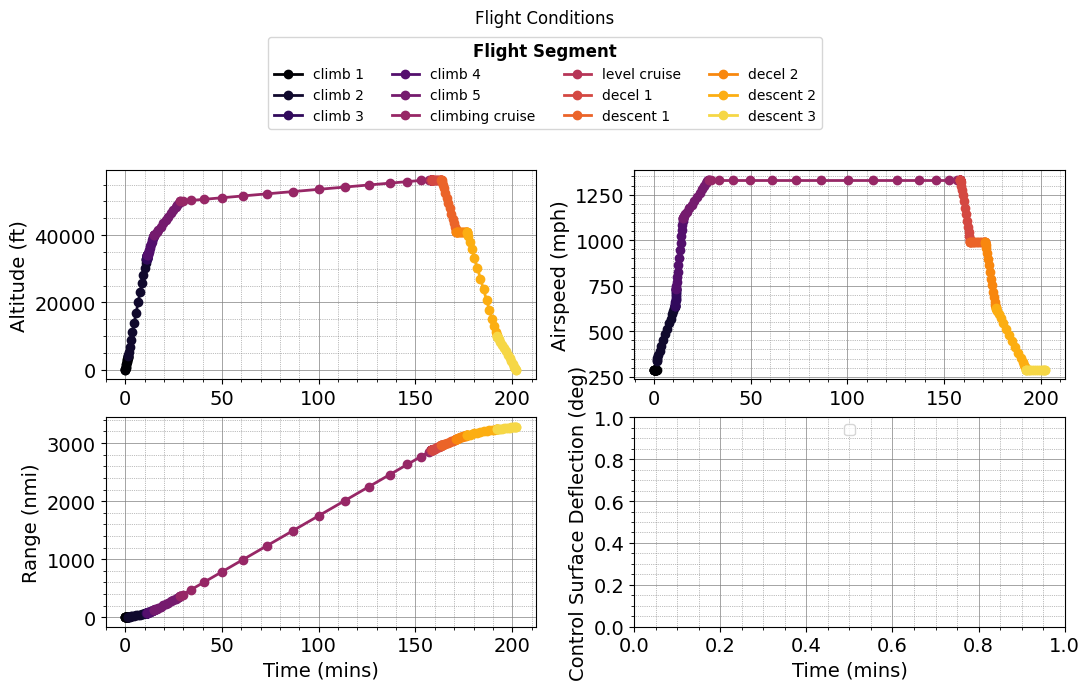




 Solving climb_2 segment.



 Solving climb_3 segment.



 Solving climb_4 segment.



 Solving climb_5 segment.



 Solving climbing_cruise segment.



 Solving level_cruise segment.



 Solving decel_1 segment.



 Solving descent_1 segment.



 Solving decel_2 segment.



 Solving descent_2 segment.



 Solving descent_3 segment.




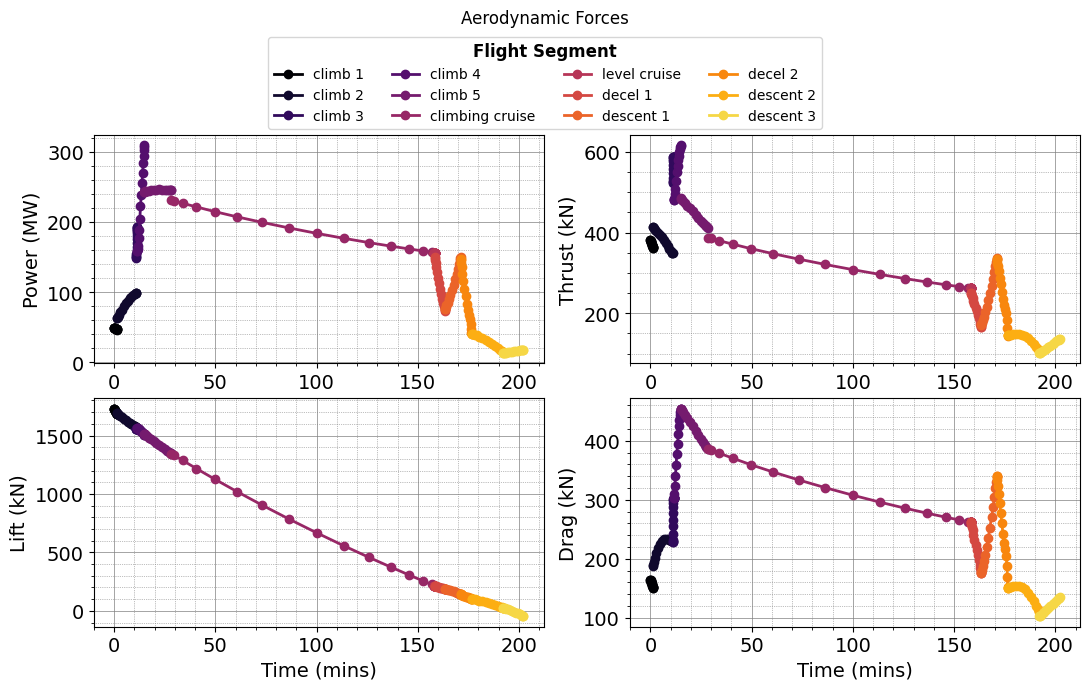

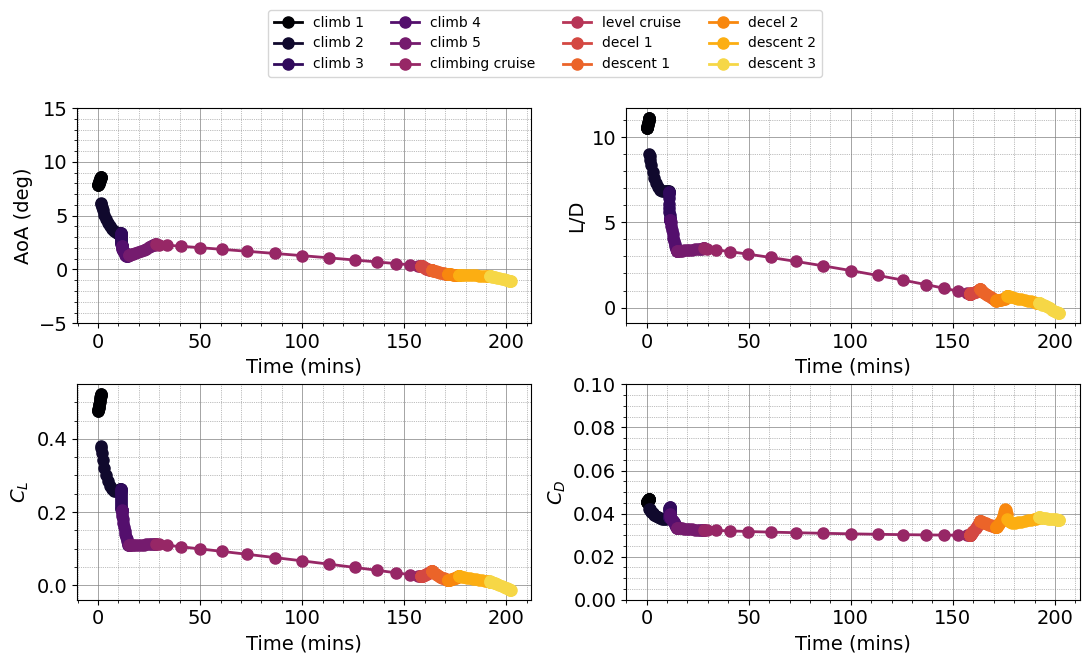

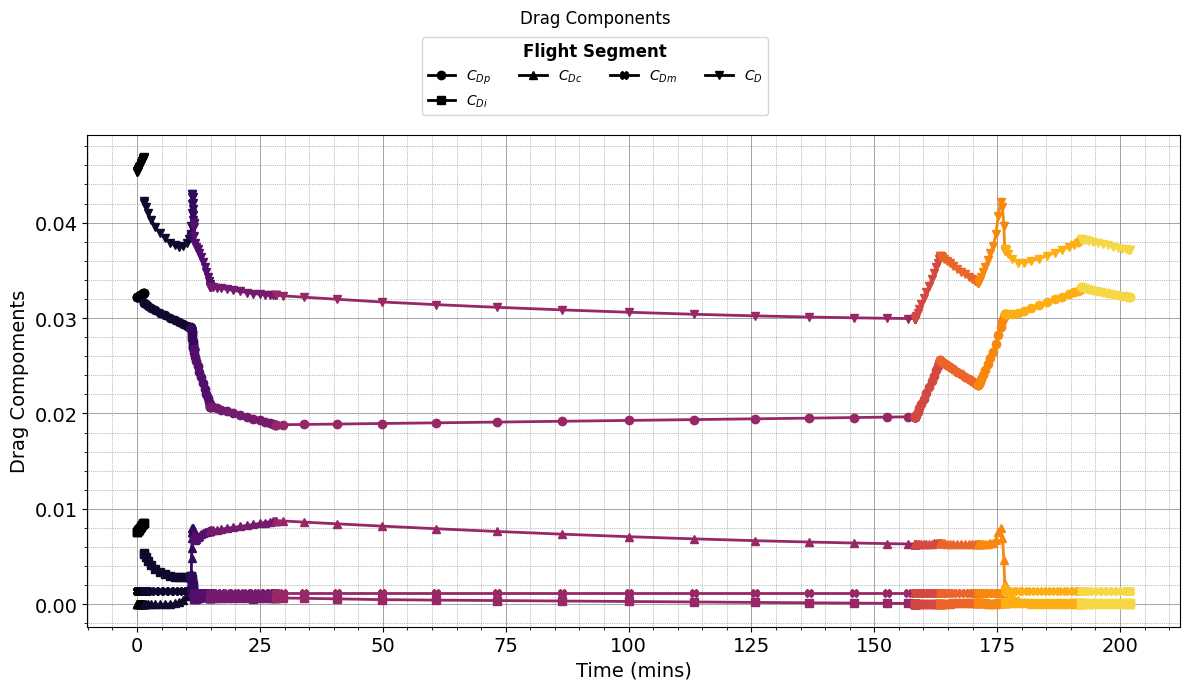

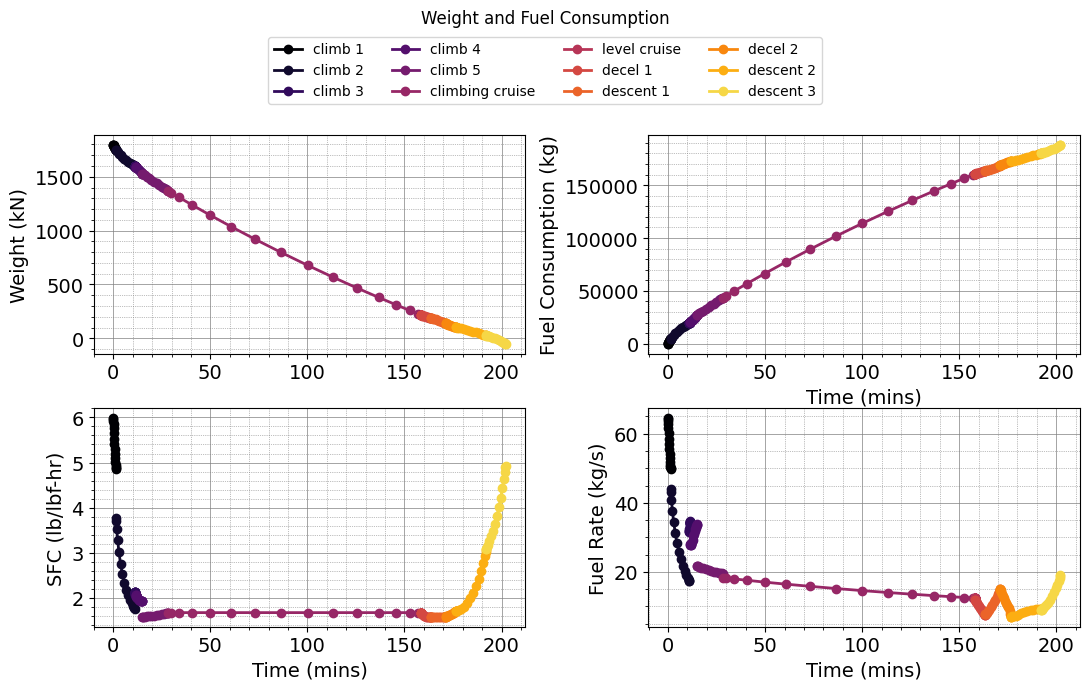

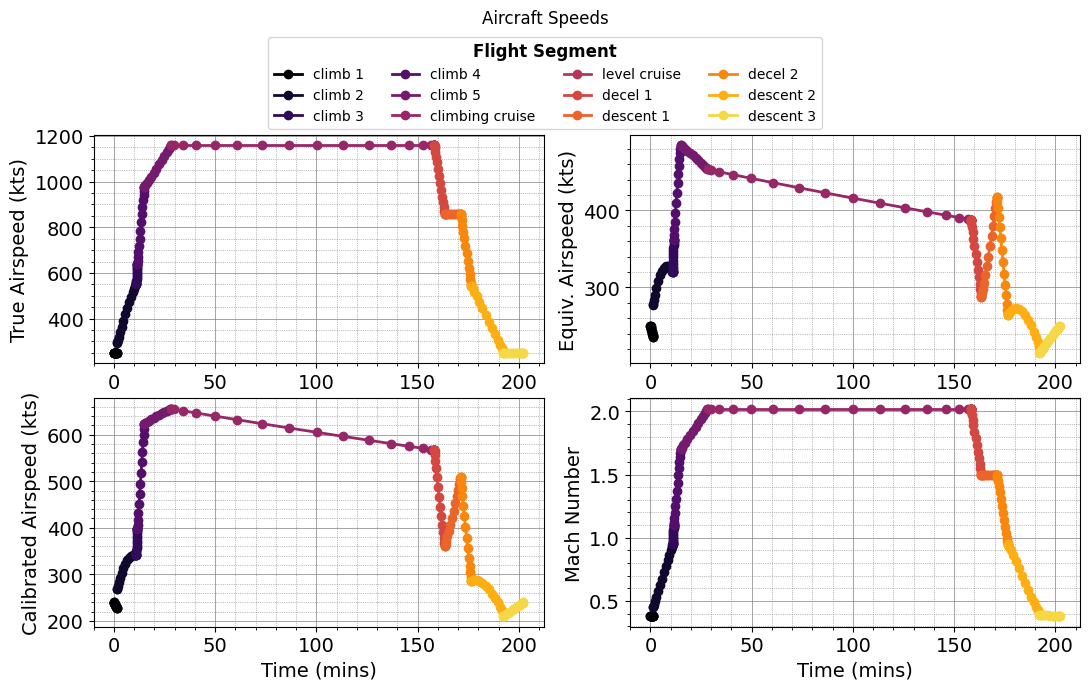

In [9]:

# ----------------------------------------------------------------------
#   Main
# ----------------------------------------------------------------------
 
# vehicle data
vehicle  = vehicle_setup()

# plot vehicle 
plot_3d_vehicle(vehicle, 
                min_x_axis_limit            = 0,
                max_x_axis_limit            = 60,
                min_y_axis_limit            = -30,
                max_y_axis_limit            = 30,
                min_z_axis_limit            = -30,
                max_z_axis_limit            = 30, 
                )             

# Set up vehicle configs
configs  = configs_setup(vehicle)

# create analyses
analyses = analyses_setup(configs)

# mission analyses 
mission = mission_setup(analyses)

# create mission instances (for multiple types of missions)
missions = missions_setup(mission) 
    
# mission analysis 
results = missions.base_mission.evaluate()  

# plot the results
plot_mission(results) 